Load the required libraries like nltk, re, matplotlib, numpy, pandas, sklearn for the project to work. Please, make sure to upload the train and test files and change the file paths accordingly.

In [42]:
import nltk
nltk.download('stopwords')
import re
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, f1_score, recall_score
from sklearn.multiclass import OneVsRestClassifier
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.pipeline import Pipeline
from gensim.models import Word2Vec
import seaborn as sns

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


This cell contains all the inputs and constants required to run the notebook. Please, set the values accordingly.

In [0]:
train_file_path = "nlp_train.csv"
test_file_path = "nlp_test.csv"
encoding = "ISO-8859-1"
text_field_label = "body"
emotions = ['anger', 'anticipation', 'disgust', 'fear', 'joy', 'love','optimism', 'pessimism', 'sadness', 'surprise', 'trust', 'neutral']

In [0]:
df_train = pd.read_csv(train_file_path, encoding = encoding)
df_test = pd.read_csv(test_file_path, encoding = encoding)

### Number of posts for each emotion for training data

In [5]:
df_train_sub = df_train.drop([text_field_label], axis=1)
counts = []
categories = list(df_train_sub.columns.values)
for i in categories:
    counts.append((i, df_train_sub[i].sum()))
df_stats_train = pd.DataFrame(counts, columns=['emotion', 'number_of_posts_train'])
df_stats_train

,emotion,number_of_posts_train
0,anger,544
1,anticipation,751
2,disgust,678
3,fear,678
4,joy,185
5,love,138
6,optimism,490
7,pessimism,646
8,sadness,414
9,surprise,162


Text(0.5, 0, 'Emotion')

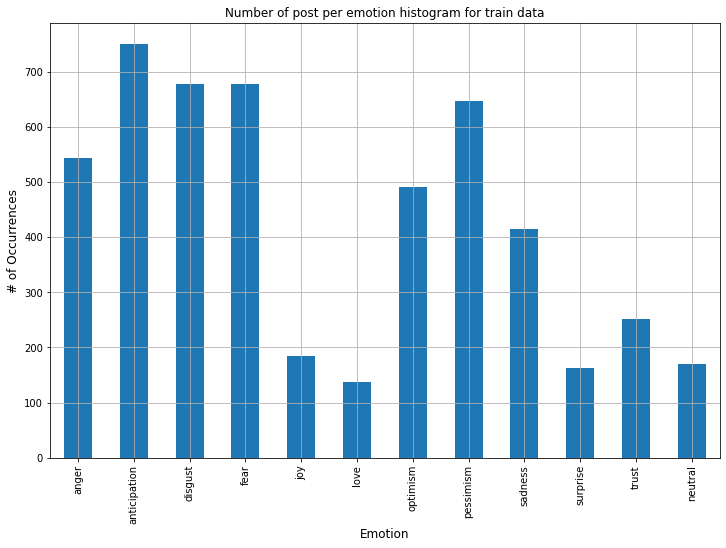

In [6]:
df_stats_train.plot(x='emotion', y='number_of_posts_train', kind='bar', legend=False, grid=True, figsize=(12, 8))
plt.title("Number of post per emotion histogram for train data")
plt.ylabel('# of Occurrences', fontsize=12)
plt.xlabel('Emotion', fontsize=12)

Post length distribution for training data

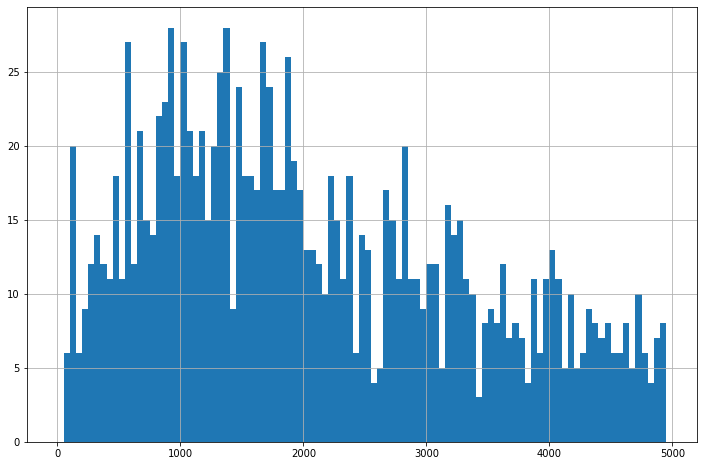

In [7]:
lens = df_train.body.str.len()
lens.hist(bins = np.arange(0,5000,50), figsize=(12,8))

In [8]:
df_test_sub = df_test.drop([text_field_label], axis=1)
counts = []
categories = list(df_test_sub.columns.values)
for i in categories:
    counts.append((i, df_test_sub[i].sum()))
df_stats_test = pd.DataFrame(counts, columns=['emotion', 'number_of_posts_test'])
df_stats_test

,emotion,number_of_posts_test
0,anger,121
1,anticipation,218
2,disgust,156
3,fear,195
4,joy,70
5,love,30
6,optimism,97
7,pessimism,120
8,sadness,136
9,surprise,49


Text(0.5, 0, 'Emotion')

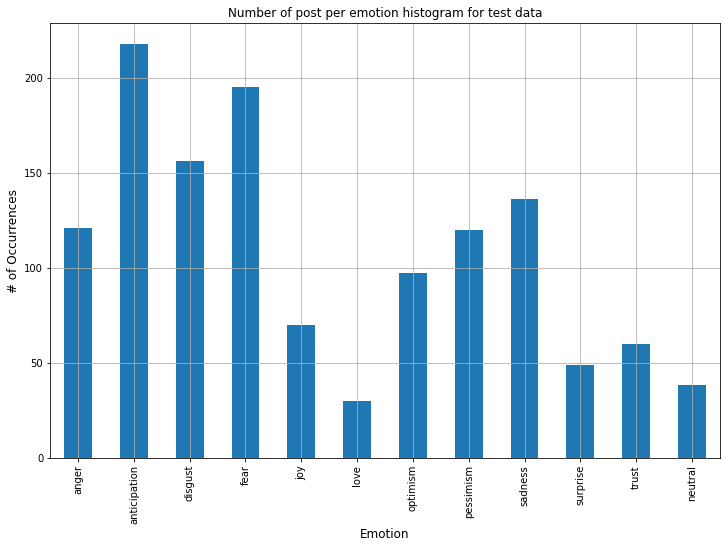

In [9]:
df_stats_test.plot(x='emotion', y='number_of_posts_test', kind='bar', legend=False, grid=True, figsize=(12, 8))
plt.title("Number of post per emotion histogram for test data")
plt.ylabel('# of Occurrences', fontsize=12)
plt.xlabel('Emotion', fontsize=12)

### Multi-Label posts distribution

We will visualize how many posts have multiple labels

Text(0.5, 0, '# of Emotions')

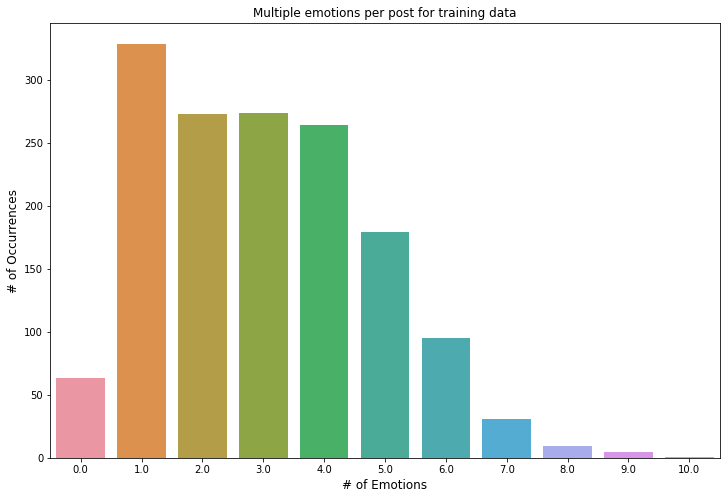

In [10]:
rowsums = df_train.iloc[:,2:].sum(axis=1)
x=rowsums.value_counts()

#plot
plt.figure(figsize=(12,8))
ax = sns.barplot(x.index, x.values)
plt.title("Multiple emotions per post for training data")
plt.ylabel('# of Occurrences', fontsize=12)
plt.xlabel('# of Emotions', fontsize=12)

Text(0.5, 0, '# of Emotions')

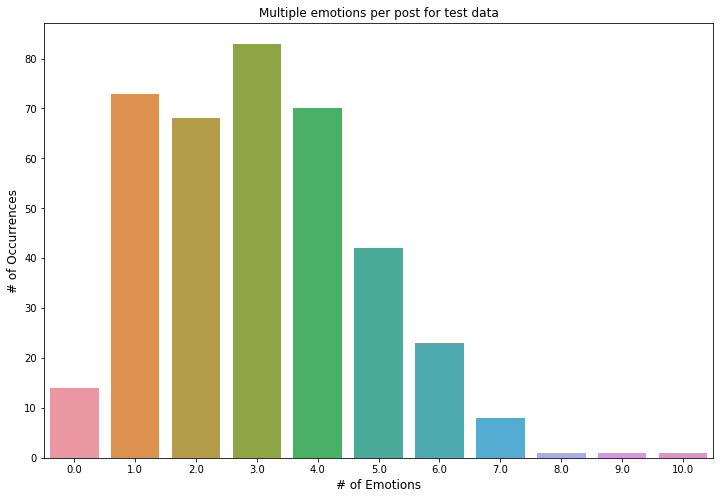

In [11]:
rowsums = df_test.iloc[:,2:].sum(axis=1)
x = rowsums.value_counts()

plt.figure(figsize=(12,8))
ax = sns.barplot(x.index, x.values)
plt.title("Multiple emotions per post for test data")
plt.ylabel('# of Occurrences', fontsize=12)
plt.xlabel('# of Emotions', fontsize=12)

### Create a function to clean the text

In [0]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "can not ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r"\'scuse", " excuse ", text)
    text = re.sub('\W', ' ', text)
    text = re.sub('\s+', ' ', text)
    text = text.strip(' ')
    return text

### Clean up posts data using regex 

In [0]:
df_train['body'] = df_train['body'].map(lambda com : clean_text(com))
df_test['body'] = df_test['body'].map(lambda com : clean_text(com))

### Drop Nan from the train and test dataframes

In [0]:
train = df_train.dropna()
test = df_test.dropna()

In [16]:
X_train = train.body
X_test = test.body
train.replace(True, 1, inplace=True)
train.replace(False, 0, inplace=True)
test.replace(True, 1, inplace=True)
test.replace(False, 0, inplace=True)
print(X_train.shape)
print(X_test.shape)

(1493,)
(374,)


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4172: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  method=method,


In [0]:
#df_emotion = pd.DataFrame(columns=['anger', 'anticipation', 'disgust', 'fear', 'joy', 'love','optimism', 'pessimism', 'sadness', 'surprise', 'trust', 'neutral'])

### Naive Bayes


In [0]:
# Define a pipeline combining a text feature extractor with multi lable classifier
NB_pipeline = Pipeline([
                ('tfidf', TfidfVectorizer(stop_words=stop_words)),
                ('clf', OneVsRestClassifier(MultinomialNB(
                    fit_prior=True, class_prior=None))),
            ])

In [30]:
nb_accuracy = []
nb_recall = []
nb_f1 = []
for emo in emotions:
    print('Processing {}'.format(emo))
    NB_pipeline.fit(X_train, train[emo])
    prediction = NB_pipeline.predict(X_test)
    print('Test accuracy is {}'.format(accuracy_score(test[emo], prediction)))
    nb_accuracy.append(accuracy_score(test[emo], prediction)*100)
    fscore = f1_score(test[emo], prediction)
    recall = recall_score(test[emo], prediction)
    nb_recall.append(recall)
    nb_f1.append(fscore)
    print('recall: {}'.format(recall))
    print('fscore: {}'.format(fscore))

Processing anger
Test accuracy is 0.6951871657754011
recall: 0.05785123966942149
fscore: 0.109375
Processing anticipation
Test accuracy is 0.6042780748663101
recall: 0.9541284403669725
fscore: 0.7375886524822695
Processing disgust
Test accuracy is 0.7540106951871658
recall: 0.6474358974358975
fscore: 0.6870748299319728
Processing fear
Test accuracy is 0.6898395721925134
recall: 0.7435897435897436
fscore: 0.7142857142857142
Processing joy
Test accuracy is 0.8128342245989305
recall: 0.0
fscore: 0.0
Processing love
Test accuracy is 0.9197860962566845
recall: 0.0
fscore: 0.0
Processing optimism
Test accuracy is 0.7406417112299465
recall: 0.0
fscore: 0.0
Processing pessimism
Test accuracy is 0.6978609625668449
recall: 0.425
fscore: 0.4744186046511628
Processing sadness
Test accuracy is 0.6363636363636364
recall: 0.0
fscore: 0.0
Processing surprise
Test accuracy is 0.8689839572192514
recall: 0.0
fscore: 0.0
Processing trust
Test accuracy is 0.839572192513369
recall: 0.0
fscore: 0.0
Processin

### LinearSVC

In [0]:
SVC_pipeline = Pipeline([
                ('tfidf', TfidfVectorizer(stop_words=stop_words)),
                ('clf', OneVsRestClassifier(LinearSVC(), n_jobs=1)),
            ])

In [31]:
svc_accuracy = []
svc_recall = []
svc_f1 = []
for emo in emotions:
    print('Processing {}'.format(emo))
    SVC_pipeline.fit(X_train, train[emo])
    prediction = SVC_pipeline.predict(X_test)
    print('Test accuracy is {}'.format(accuracy_score(test[emo], prediction)))
    svc_accuracy.append(accuracy_score(test[emo], prediction)*100)
    fscore = f1_score(test[emo], prediction)
    recall = recall_score(test[emo], prediction)
    svc_recall.append(recall)
    svc_f1.append(fscore)
    print('recall: {}'.format(recall))
    print('fscore: {}'.format(fscore))

Processing anger
Test accuracy is 0.7486631016042781
recall: 0.5206611570247934
fscore: 0.5727272727272726
Processing anticipation
Test accuracy is 0.6256684491978609
recall: 0.6605504587155964
fscore: 0.6728971962616822
Processing disgust
Test accuracy is 0.7192513368983957
recall: 0.6666666666666666
fscore: 0.6645367412140575
Processing fear
Test accuracy is 0.6764705882352942
recall: 0.5948717948717949
fscore: 0.6572237960339944
Processing joy
Test accuracy is 0.820855614973262
recall: 0.08571428571428572
fscore: 0.1518987341772152
Processing love
Test accuracy is 0.9197860962566845
recall: 0.03333333333333333
fscore: 0.0625
Processing optimism
Test accuracy is 0.6978609625668449
recall: 0.32989690721649484
fscore: 0.3615819209039548
Processing pessimism
Test accuracy is 0.6818181818181818
recall: 0.6
fscore: 0.5475285171102662
Processing sadness
Test accuracy is 0.6657754010695187
recall: 0.2426470588235294
fscore: 0.34554973821989526
Processing surprise
Test accuracy is 0.87433155

### Logistic Regression

In [32]:
LogReg_pipeline = Pipeline([
                ('tfidf', TfidfVectorizer(stop_words=stop_words)),
                ('clf', OneVsRestClassifier(LogisticRegression(solver='sag'), n_jobs=1)),
            ])

lg_accuracy = []
lg_recall = []
lg_f1 = []
for emo in emotions:
    print('Processing {}'.format(emo))
    # train the model using X_dtm & y
    LogReg_pipeline.fit(X_train, train[emo])
    # compute the testing accuracy
    prediction = LogReg_pipeline.predict(X_test)
    print('Test accuracy is {}'.format(accuracy_score(test[emo], prediction)))
    lg_accuracy.append(accuracy_score(test[emo], prediction)*100)
    fscore = f1_score(test[emo], prediction)
    recall = recall_score(test[emo], prediction)
    lg_recall.append(recall)
    lg_f1.append(fscore)
    print('recall: {}'.format(recall))
    print('fscore: {}'.format(fscore))

Processing anger
Test accuracy is 0.767379679144385
recall: 0.4132231404958678
fscore: 0.5347593582887701
Processing anticipation
Test accuracy is 0.6524064171122995
recall: 0.6513761467889908
fscore: 0.6859903381642513
Processing disgust
Test accuracy is 0.732620320855615
recall: 0.6666666666666666
fscore: 0.6753246753246753
Processing fear
Test accuracy is 0.6871657754010695
recall: 0.5538461538461539
fscore: 0.6486486486486487
Processing joy
Test accuracy is 0.8128342245989305
recall: 0.0
fscore: 0.0
Processing love
Test accuracy is 0.9197860962566845
recall: 0.0
fscore: 0.0
Processing optimism
Test accuracy is 0.7459893048128342
recall: 0.15463917525773196
fscore: 0.24
Processing pessimism
Test accuracy is 0.7192513368983957
recall: 0.5416666666666666
fscore: 0.5531914893617021
Processing sadness
Test accuracy is 0.660427807486631
recall: 0.07352941176470588
fscore: 0.1360544217687075
Processing surprise
Test accuracy is 0.8743315508021391
recall: 0.04081632653061224
fscore: 0.0784

Random Forest Classifier

In [38]:
Random_pipeline = Pipeline([
                ('tfidf', TfidfVectorizer(stop_words=stop_words)),
                ('clf', OneVsRestClassifier(RandomForestClassifier(n_estimators=100, max_depth=2, random_state=0), n_jobs=1)),
            ])

rf_accuracy = []
rf_recall = []
rf_f1 = []
for emo in emotions:
    print('Processing {}'.format(emo))
    Random_pipeline.fit(X_train, train[emo])
    prediction = Random_pipeline.predict(X_test)
    print('Test accuracy is {}'.format(accuracy_score(test[emo], prediction)))
    rf_accuracy.append(accuracy_score(test[emo], prediction)*100)
    fscore = f1_score(test[emo], prediction)
    recall = recall_score(test[emo], prediction)
    rf_recall.append(recall)
    rf_f1.append(fscore)
    print('recall: {}'.format(recall))
    print('fscore: {}'.format(fscore))

Processing anger
Test accuracy is 0.6764705882352942
recall: 0.0
fscore: 0.0
Processing anticipation
Test accuracy is 0.6176470588235294
recall: 0.5596330275229358
fscore: 0.6304909560723514
Processing disgust
Test accuracy is 0.5989304812834224
recall: 0.038461538461538464
fscore: 0.07407407407407407
Processing fear
Test accuracy is 0.5213903743315508
recall: 0.09230769230769231
fscore: 0.1674418604651163
Processing joy
Test accuracy is 0.8128342245989305
recall: 0.0
fscore: 0.0
Processing love
Test accuracy is 0.9197860962566845
recall: 0.0
fscore: 0.0
Processing optimism
Test accuracy is 0.7406417112299465
recall: 0.0
fscore: 0.0
Processing pessimism
Test accuracy is 0.6764705882352942
recall: 0.0
fscore: 0.0
Processing sadness
Test accuracy is 0.6363636363636364
recall: 0.0
fscore: 0.0
Processing surprise
Test accuracy is 0.8689839572192514
recall: 0.0
fscore: 0.0
Processing trust
Test accuracy is 0.839572192513369
recall: 0.0
fscore: 0.0
Processing neutral
Test accuracy is 0.89839

Gradient Boosting

In [41]:
gb_pipeline = Pipeline([
                ('tfidf', TfidfVectorizer(stop_words=stop_words)),
                ('clf', OneVsRestClassifier(GradientBoostingClassifier(n_estimators=20, learning_rate=0.1, max_features=2, max_depth=2, random_state=0), n_jobs=1)),
            ])

gb_accuracy = []
gb_recall = []
gb_f1 = []
for emo in emotions:
    print('Processing {}'.format(emo))
    gb_pipeline.fit(X_train, train[emo])
    prediction = gb_pipeline.predict(X_test)
    print('Test accuracy is {}'.format(accuracy_score(test[emo], prediction)))
    gb_accuracy.append(accuracy_score(test[emo], prediction)*100)
    fscore = f1_score(test[emo], prediction)
    recall = recall_score(test[emo], prediction)
    gb_recall.append(recall)
    gb_f1.append(fscore)
    print('recall: {}'.format(recall))
    print('fscore: {}'.format(fscore))

Processing anger
Test accuracy is 0.6764705882352942
recall: 0.0
fscore: 0.0
Processing anticipation
Test accuracy is 0.5187165775401069
recall: 0.40825688073394495
fscore: 0.49720670391061444
Processing disgust
Test accuracy is 0.5855614973262032
recall: 0.019230769230769232
fscore: 0.037267080745341616
Processing fear
Test accuracy is 0.48663101604278075
recall: 0.020512820512820513
fscore: 0.039999999999999994
Processing joy
Test accuracy is 0.8128342245989305
recall: 0.0
fscore: 0.0
Processing love
Test accuracy is 0.9197860962566845
recall: 0.0
fscore: 0.0
Processing optimism
Test accuracy is 0.7406417112299465
recall: 0.0
fscore: 0.0
Processing pessimism
Test accuracy is 0.6818181818181818
recall: 0.008333333333333333
fscore: 0.01652892561983471
Processing sadness
Test accuracy is 0.6363636363636364
recall: 0.0
fscore: 0.0
Processing surprise
Test accuracy is 0.8689839572192514
recall: 0.0
fscore: 0.0
Processing trust
Test accuracy is 0.839572192513369
recall: 0.0
fscore: 0.0
Pro

In [35]:
emo_label = emotions
models = ['Random Forest', 'Logistic Regression', 'Linear SVC', 'Naive Bayes']

results = {'Classifier':emo_label, 'Random Forest':rf_accuracy, 'Logistic Regression':lg_accuracy, 'Linear SVC':svc_accuracy, 'Naive_Bayes':nb_accuracy}
result_df = pd.DataFrame(results)
result_df.set_index("Classifier", inplace = True) 
#result_df
result_t = result_df.T
result_t

Classifier,anger,anticipation,disgust,fear,joy,love,optimism,pessimism,sadness,surprise,trust,neutral
Random Forest,67.647059,61.764706,59.893048,52.139037,81.283422,91.97861,74.064171,67.647059,63.636364,86.898396,83.957219,89.839572
Logistic Regression,76.737968,65.240642,73.262032,68.716578,81.283422,91.97861,74.598930,71.925134,66.042781,87.433155,84.759358,89.839572
Linear SVC,74.866310,62.566845,71.925134,67.647059,82.085561,91.97861,69.786096,68.181818,66.577540,87.433155,85.026738,89.037433
Naive_Bayes,69.518717,60.427807,75.401070,68.983957,81.283422,91.97861,74.064171,69.786096,63.636364,86.898396,83.957219,89.839572


In [37]:
models = ['Random Forest', 'Logistic Regression', 'Linear SVC', 'Naive Bayes']
results_f1 = {'Classifier':emotions, 'Random Forest':rf_f1, 'Logistic Regression':lg_f1, 'Linear SVC':svc_f1, 'Naive_Bayes':nb_f1}
result_df_f1 = pd.DataFrame(results_f1)
result_df_f1.set_index("Classifier", inplace = True) 
#result_df
result_t_f1 = result_df_f1.T
result_t_f1

Classifier,anger,anticipation,disgust,fear,joy,love,optimism,pessimism,sadness,surprise,trust,neutral
Random Forest,0.000000,0.630491,0.074074,0.167442,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
Logistic Regression,0.534759,0.685990,0.675325,0.648649,0.000000,0.0000,0.240000,0.553191,0.136054,0.078431,0.095238,0.00000
Linear SVC,0.572727,0.672897,0.664537,0.657224,0.151899,0.0625,0.361582,0.547529,0.345550,0.113208,0.176471,0.12766
Naive_Bayes,0.109375,0.737589,0.687075,0.714286,0.000000,0.0000,0.000000,0.474419,0.000000,0.000000,0.000000,0.00000


In [36]:
models = ['Random Forest', 'Logistic Regression', 'Linear SVC', 'Naive Bayes']
results_recall = {'Classifier':emotions, 'Random Forest':rf_recall, 'Logistic Regression':lg_recall, 'Linear SVC':svc_recall, 'Naive_Bayes':nb_recall}
result_df_recall = pd.DataFrame(results_recall)
result_df_recall.set_index("Classifier", inplace = True) 
#result_df
result_t_recall = result_df_recall.T
result_t_recall

Classifier,anger,anticipation,disgust,fear,joy,love,optimism,pessimism,sadness,surprise,trust,neutral
Random Forest,0.000000,0.559633,0.038462,0.092308,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000
Logistic Regression,0.413223,0.651376,0.666667,0.553846,0.000000,0.000000,0.154639,0.541667,0.073529,0.040816,0.05,0.000000
Linear SVC,0.520661,0.660550,0.666667,0.594872,0.085714,0.033333,0.329897,0.600000,0.242647,0.061224,0.10,0.078947
Naive_Bayes,0.057851,0.954128,0.647436,0.743590,0.000000,0.000000,0.000000,0.425000,0.000000,0.000000,0.00,0.000000


In [28]:
result_agg = result_df.agg("mean", axis="rows")
result_agg.columns = ["classifier", "accuracy"]
result_agg

Random Forest          73.395722
Logistic Regression    77.651515
Linear SVC             76.426025
Naive_Bayes            76.314617
dtype: float64

Text(0.5, 0, 'Classifier')

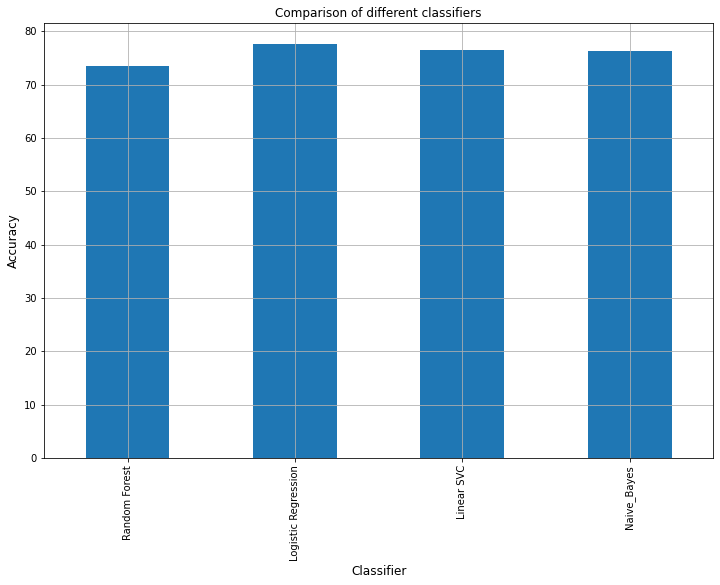

In [29]:
result_agg.plot(x='classifier', y='accuracy', kind='bar', legend=False, grid=True, figsize=(12, 8))
plt.title("Comparison of different classifiers")
plt.ylabel('Accuracy', fontsize=12)
plt.xlabel('Classifier', fontsize=12)

In [0]:
import spacy
import en_core_web_sm
import gensim
from gensim import models
from gensim.test import utils
import numpy as np
import re
import glob
from smart_open import smart_open
import os
import gensim
from gensim.models import Doc2Vec
from gensim.models.doc2vec import TaggedDocument
from sklearn import utils
from collections import namedtuple, defaultdict
import logging
from sklearn.feature_extraction.text import TfidfVectorizer

# Source : https://github.com/elaine-peiru/Thesis_final/blob/master/UtilWordEmbedding.py
# Convert text to lower-case and strip punctuation/symbols from words
def normalize_text(text):
	"""
	Ref: https://stackoverflow.com/questions/20802056/python-regular-expression-1
	:param text: string
	:return:
		clean string
	"""
	norm_text = text.lower()
	# Replace breaks with spaces
	norm_text = norm_text.replace('<br />', ' ')
	# Pad punctuation with spaces on both sides
	norm_text = re.sub(r"([\.\",\(\)!\?;:])", r" \1 ", norm_text)
	return norm_text


def concat_files(dirname, folders):
	"""
	Concatenate text from files to one file, and return a file list.
	:param dirname: string of directory
	:param folders: list of folder names
	:return
		files: list of file paths
	"""
	files = []

	for fol in folders:
		output = fol.replace('/', '-') + '.txt'
		txt_files = glob.glob(os.path.join(dirname, fol, '*.txt'))
		print('{} records in {}...'.format(len(txt_files), output))
		files.append(output)

		with smart_open(os.path.join(dirname, output), 'wb') as n:
			for i, txt in enumerate(txt_files):
				with smart_open(txt, 'rb') as f:
					one_text = f.read().decode('utf-8')  # from binary to string
					one_text = normalize_text(one_text)  # convert to lower-case and strip punctuations
					n.write(one_text.encode('utf-8') + b'\n')  # from string to binary + newline

	return files


def select_imdb(select_num, dirname, files, file_splits, file_sentiments):
	"""
	Subset and split IMDB dataset into train/test.
	:param select_num: num of rows to select
	:param dirname: directory of txt files
	:param files: list of string name of files
	:param file_splits: list of string on train/test split
	:param file_sentiments: list of string on pos/neg sentiment label
	:return:
		list of namedtuple
	"""

	sent_doc = namedtuple('sent_doc', ['words', 'tags', 'split', 'sentiment'])
	all_doc = []
	doc_id = 0
	for i, fi in enumerate(files[:-1]):
		s_ = file_splits[i]
		se_ = file_sentiments[i]

		with smart_open(os.path.join(dirname, fi), 'rb', encoding='utf-8') as texts:
			for line_no, line in enumerate(texts):
				if line_no < select_num:
					tokens = gensim.utils.to_unicode(line).split()
					words = tokens  # must be a list for doc2vec
					tags = [doc_id]  # must be a list for doc2vec
					doc_id += 1
					split = s_
					sentiment = se_
					all_doc.append(sent_doc(words, tags, split, sentiment))
				else:
					break

	return all_doc


class DocPreprocess(object):

	def __init__(self,
				 nlp,
				 stop_words,
				 docs,
				 labels,
				 build_bi=False,
				 min_count=5,
				 threshold=10,
				 allowed_postags=['ADV', 'VERB', 'ADJ', 'NOUN', 'PROPN', 'NUM']):

		self.nlp = nlp  # spacy nlp object
		self.stop_words = stop_words  # spacy.lang.en.stop_words.STOP_WORDS
		self.docs = docs  # docs must be either list or numpy array or series of docs
		self.labels = labels # labels must be list or or numpy array or series of labels
		self.doc_ids = np.arange(len(docs))
		self.simple_doc_tokens = [gensim.utils.simple_preprocess(doc, deacc=True) for doc in self.docs]

		if build_bi:
			self.bi_detector = self.build_bi_detect(self.simple_doc_tokens, min_count=min_count, threshold=threshold)
			self.new_docs = self.make_bigram_doc(self.bi_detector, self.simple_doc_tokens)
		else:
			self.new_docs = self.make_simple_doc(self.simple_doc_tokens)
		self.doc_words = [self.lemmatize(doc, allowed_postags=allowed_postags) for doc in self.new_docs]
		self.tagdocs = [TaggedDocument(words=words, tags=[tag]) for words, tag in zip(self.doc_words, self.doc_ids)]


	def build_bi_detect(self, simple_doc_tokens, min_count, threshold):
		bi_ = gensim.models.phrases.Phrases(simple_doc_tokens, min_count=min_count, threshold=threshold)
		bi_detector = gensim.models.phrases.Phraser(bi_)  # wrapper enhance efficiency
		return bi_detector


	def make_bigram_doc(self, bi_detector, simple_doc_tokens):
		bi_doc_tokens = [bi_detector[doc_tokens] for doc_tokens in simple_doc_tokens]
		bi_docs = []
		for bi_tokens in bi_doc_tokens:
			bi_doc = " ".join(bi_tokens)  # concatenate back to a sentence
			bi_docs.append(bi_doc)
		return bi_docs


	def make_simple_doc(self, simple_doc_tokens):
		simple_docs = []
		for doc_tokens in simple_doc_tokens:
			simple = " ".join(doc_tokens)  # concatenate back to a sentence
			simple_docs.append(simple)
		return simple_docs


	def lemmatize(self, doc, allowed_postags):
		"""
		Lemmatize words and remove stop_words.
		:param doc: text
		:param allowed_postags: list of pos tags
		:return:
			list of tokens
		"""
		doc = self.nlp(doc)
		tokens = [token.lemma_ for token in doc if (
				token.pos_ in allowed_postags) and (token.text not in self.stop_words)]
		return tokens



class DocModel(object):

	def __init__(self, docs, **kwargs):
		"""
		:param docs: list of TaggedDocument
		:param kwargs: dictionary of (key,value) for Doc2Vec arguments
		"""
		self.model = Doc2Vec(**kwargs)
		self.docs = docs
		self.model.build_vocab([x for x in self.docs])

	def custom_train(self, fixed_lr=False, fixed_lr_epochs=None):
		"""
		Train Doc2Vec with two options, without fixed learning rate(recommended) or with fixed learning rate.
		Fixed learning rate also includes implementation of shuffling training dataset.
		:param fixed_lr: boolean
		:param fixed_lr_epochs: num of epochs for fixed lr training
		"""
		if not fixed_lr:
			self.model.train([x for x in self.docs],
							 total_examples=len(self.docs),
							 epochs=self.model.epochs)
		else:
			for _ in range(fixed_lr_epochs):
				self.model.train(utils.shuffle([x for x in self.docs]),
								 total_examples=len(self.docs),
								 epochs=1)
				self.model.alpha -= 0.002
				self.model.min_alpha = self.model.alpha  # fixed learning rate


	def test_orig_doc_infer(self):
		"""
		Use the original doc as input for model's vector inference,
		and then compare using most_similar()
		to see if model finds the original doc id be the most similar doc to the input.
		"""
		idx = np.random.randint(len(self.docs))
		print('idx: ' + str(idx))
		doc = [doc for doc in self.docs if doc.tags[0] == idx]
		inferred_vec = self.model.infer_vector(doc[0].words)
		print(self.model.docvecs.most_similar([inferred_vec]))  # wrap vec in a list


class MeanEmbeddingVectorizer(object):


	def __init__(self, word_model):
		self.word_model = word_model
		self.vector_size = word_model.wv.vector_size

	def fit(self):  # comply with scikit-learn transformer requirement
		return self

	def transform(self, docs):  # comply with scikit-learn transformer requirement
		doc_word_vector = self.word_average_list(docs)
		return doc_word_vector

	def word_average(self, sent):
		"""
		Compute average word vector for a single doc/sentence.
		:param sent: list of sentence tokens
		:return:
			mean: float of averaging word vectors
		"""
		mean = []
		for word in sent:
			if word in self.word_model.wv.vocab:
				mean.append(self.word_model.wv.get_vector(word))

		if not mean:  # empty words
			# If a text is empty, return a vector of zeros.
			logging.warning("cannot compute average owing to no vector for {}".format(sent))
			return np.zeros(self.vector_size)
		else:
			mean = np.array(mean).mean(axis=0)
			return mean


	def word_average_list(self, docs):
		"""
		Compute average word vector for multiple docs, where docs had been tokenized.
		:param docs: list of sentence in list of separated tokens
		:return:
			array of average word vector in shape (len(docs),)
		"""
		return np.vstack([self.word_average(sent) for sent in docs])


class TfidfEmbeddingVectorizer(object):

	def __init__(self, word_model):

		self.word_model = word_model
		self.word_idf_weight = None
		self.vector_size = word_model.wv.vector_size

	def fit(self, docs):  # comply with scikit-learn transformer requirement
		"""
		Fit in a list of docs, which had been preprocessed and tokenized,
		such as word bi-grammed, stop-words removed, lemmatized, part of speech filtered.
		Then build up a tfidf model to compute each word's idf as its weight.
		Noted that tf weight is already involved when constructing average word vectors, and thus omitted.
		:param
			pre_processed_docs: list of docs, which are tokenized
		:return:
			self
		"""

		text_docs = []
		for doc in docs:
			text_docs.append(" ".join(doc))

		tfidf = TfidfVectorizer()
		tfidf.fit(text_docs)  # must be list of text string

		# if a word was never seen - it must be at least as infrequent
		# as any of the known words - so the default idf is the max of
		# known idf's
		max_idf = max(tfidf.idf_)  # used as default value for defaultdict
		self.word_idf_weight = defaultdict(lambda: max_idf,
										   [(word, tfidf.idf_[i]) for word, i in tfidf.vocabulary_.items()])
		return self


	def transform(self, docs):  # comply with scikit-learn transformer requirement
		doc_word_vector = self.word_average_list(docs)
		return doc_word_vector


	def word_average(self, sent):
		"""
		Compute average word vector for a single doc/sentence.
		:param sent: list of sentence tokens
		:return:
			mean: float of averaging word vectors
		"""

		mean = []
		for word in sent:
			if word in self.word_model.wv.vocab:
				mean.append(self.word_model.wv.get_vector(word) * self.word_idf_weight[word])  # idf weighted

		if not mean:  # empty words
			# If a text is empty, return a vector of zeros.
			logging.warning("cannot compute average owing to no vector for {}".format(sent))
			return np.zeros(self.vector_size)
		else:
			mean = np.array(mean).mean(axis=0)
			return mean


	def word_average_list(self, docs):
		"""
		Compute average word vector for multiple docs, where docs had been tokenized.
		:param docs: list of sentence in list of separated tokens
		:return:
			array of average word vector in shape (len(docs),)
		"""
		return np.vstack([self.word_average(sent) for sent in docs])


In [0]:

#nlp = spacy.load('en_core_web_md')
nlp = en_core_web_sm.load()
stop_words = spacy.lang.en.stop_words.STOP_WORDS
all_joy = DocPreprocess(nlp, stop_words, train['body'], train['joy'])

In [0]:
word_model = Word2Vec(all_joy.doc_words, min_count=2, size=100, window=5, workers=2, iter=100)

In [54]:
tfidf_vec_tr = TfidfEmbeddingVectorizer(word_model)
tfidf_vec_tr.fit(all_joy.doc_words)  # fit tfidf model first
tfidf_doc_vec = tfidf_vec_tr.transform(all_joy.doc_words)
display(tfidf_doc_vec.shape)
dir_path = "./"
np.savetxt(os.path.join(dir_path, 'tfidf_doc_vec.csv'), tfidf_doc_vec, delimiter=',')

(1493, 100)

In [0]:
import os

tfidf_doc_vec = pd.read_csv(os.path.join(dir_path, 'tfidf_doc_vec.csv'), header=None)
